# 本文件用于基础数据准备
- 上海乡镇矢量数据:要素属性匹配
- 第六次人口普查数据:清洗与整理


In [1]:
# 初始化依赖包与qgis
import os
import numpy as np
import pandas as pd


import geopandas as gpd
import matplotlib.pyplot as plt

# import pyqgis
from qgis.core import *

# Supply path to qgis install location
QgsApplication.setPrefixPath('/Applications/QGIS-LTR.app/Contents/MacOS', True)

# Create a reference to the QgsApplication.  Setting the
# second argument to False disables the GUI.
qgs = QgsApplication([], False)

# Load providers
qgs.initQgis()

# Write your code here to load some layers, use processing
# algorithms, etc.

# Finally, exitQgis() is called to remove the
# provider and layer registries from memory


from qgis.analysis import QgsNativeAlgorithms
import processing
from processing.core.Processing import Processing
Processing.initialize()
QgsApplication.processingRegistry().addProvider(QgsNativeAlgorithms())
qgs.exitQgis()

Logged warning: Duplicate provider native registered


# 1. 上海乡镇矢量数据属性整理
   
* 本部分整理`上海乡镇矢量数据.shp` (来源于`百度地图`)属性,将其与上海市第六次人口普查数据(来源于`中华人民共和国政区大典`)融合,获取项目所需基础数据.

## 1.1 加载矢量图层

In [2]:
shanghai_town_filepath = r'/Users/oo/Desktop/5.Learning/esri-ces-contest/Codes/input_data/shanghai/上海市_乡镇边界.shp'
shanghai_county_filepath = r'/Users/oo/Desktop/5.Learning/esri-ces-contest/Codes/input_data/shanghai/上海市_县界.shp'
sh_town_layer = QgsVectorLayer(shanghai_town_filepath, "Shanghai Town", "ogr")
sh_county_layer = QgsVectorLayer(shanghai_county_filepath, "Shanghai County", "ogr")

## 1.2 转换编码为GBK,避免属性表乱码

In [3]:
sh_town_layer.setProviderEncoding(u'GBK')
sh_county_layer.setProviderEncoding(u'GBK')

## 1.3 建立函数获取矢量图层属性表,转换为DataFrame

In [4]:
def getAttributeTable(vlayer):
    """ get attribute table of a vector layer.
    
    Args:
        vlayer : (QgsVectorLayer instance). vector layer

    returns:
         pandas DataFrame: attribute table
    """
    attribute_dict={}
    
    for field in vlayer.fields(): # 初始化各要素属性为空列表
        attribute_dict[field.name()] = []
        
    for feature in vlayer.getFeatures(): # 遍历矢量图层中个要素
        for field in vlayer.fields(): # 遍历各属性字段
            attribute_dict[field.name()].append(feature[field.name()]) # 添加属性字段值进入字典
            
            
    return pd.DataFrame(attribute_dict) #返回DataFrame

## 1.4 合并区县与乡镇属性表,使得乡镇属性表包括区县字段

In [5]:
shangtown_attribute_table = getAttributeTable(sh_town_layer)
shangtown_attribute_table['code_front6'] = shangtown_attribute_table['code'].apply(lambda row: row[0:6]) # 利用乡镇数据code前6位对应区县前六位进行匹配
shangcounty_attribute_table = getAttributeTable(sh_county_layer)
shangcounty_attribute_table['code_front6'] = shangcounty_attribute_table['code'].apply(lambda row: row[0:6])
shangtown_merge = shangtown_attribute_table.merge(shangcounty_attribute_table[['Name', 'code', 'code_front6']], 
                                how='left', on='code_front6', suffixes=('_town', '_county')) # 合并乡镇与区县属性表
display(shangtown_merge)


,gml_id,Name_town,layer,code_town,grade,code_front6,Name_county,code_county
0,layer_township_pg.1,江桥镇,乡镇,310114118000,4,310114,嘉定区,310114000000
1,layer_township_pg.2,菊园新区管委会,乡镇,310114003000,4,310114,嘉定区,310114000000
2,layer_township_pg.3,外冈镇,乡镇,310114114000,4,310114,嘉定区,310114000000
3,layer_township_pg.4,南翔镇,乡镇,310114102000,4,310114,嘉定区,310114000000
4,layer_township_pg.5,新成路街道,乡镇,310114001000,4,310114,嘉定区,310114000000
...,...,...,...,...,...,...,...,...
246,layer_township_pg.27567,姚庄镇,乡镇,330421111000,4,330421,嘉善县,330421000000
247,layer_township_pg.27571,新仓镇,乡镇,330482103000,4,330482,平湖市,330482000000
248,layer_township_pg.27574,广陈镇,乡镇,330482106000,4,330482,平湖市,330482000000
249,layer_township_pg.27575,新埭镇,乡镇,330482102000,4,330482,平湖市,330482000000


In [6]:
# 输出结果
# shangtown_merge.to_csv('output_data/上海乡镇单元人口普查统计.csv', index=False, encoding='utf_8_sig')

# 2. 链家数据统计街道房屋均价

## 2.1 查看乡镇矢量的坐标系

In [7]:
sh_town_layer.crs()

<QgsCoordinateReferenceSystem: EPSG:4326>

## 2.2 导入房价数据(链家获取),并展示属性表

In [8]:
house_pricing_shp = r'/Users/oo/Desktop/5.Learning/esri-ces-contest/Codes/input_data/shanghai_house_price.shp'
sh_house_layer = QgsVectorLayer(house_pricing_shp, 'Shanghai House Price', 'ogr')
getAttributeTable(sh_house_layer)

,name,price,county,town,address,lng_wgs84,lat_wgs84
0,上海玫瑰园商贸城,5442,奉贤,奉城,(奉贤奉城)南奉公路999弄,121.617538,30.915823
1,平安家园,5523,奉贤,四团,(奉贤四团)平福路1625弄,121.739173,30.898313
2,燎原农场,6034,奉贤,海湾,"(奉贤海湾)燎原农场运输楼, 燎原农场供销楼, 燎原农场燎原设备楼, 燎原农场医院楼, 燎原农场场部楼",121.652068,30.861294
3,褚聚街4号,6090,奉贤,奉城,(奉贤奉城)褚聚街4号,121.612381,30.902529
4,泊兰花苑,6412,松江,泗泾,(松江泗泾)张泾路1339弄,121.275846,31.104524
...,...,...,...,...,...,...,...
12730,中邦晶座,98291,浦东,联洋,(浦东联洋)丁香路1066弄,121.551680,31.229577
12731,霍山路66弄,98507,虹口,北外滩,(虹口北外滩)霍山路66弄,121.505928,31.255162
12732,东方丰甸苑(别墅),98582,浦东,南码头,(浦东南码头)东方路2995弄,121.515086,31.195889
12733,东昌新村,99917,浦东,陆家嘴,"(浦东陆家嘴)东昌新村, 东宁路348号, 东宁路350号, 东宁路360号",121.507249,31.234651


## 2.3 利用geopandas展示一下

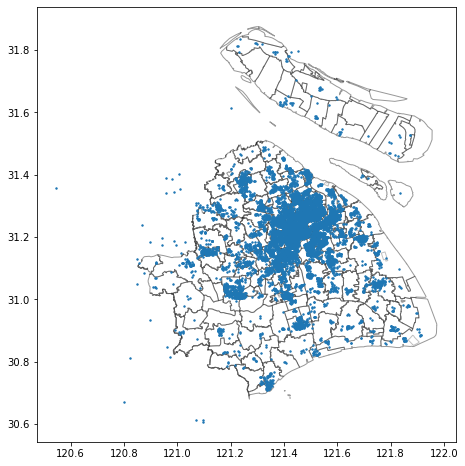

In [21]:
sh_town_gpd = gpd.read_file(shanghai_town_filepath,encoding='gbk')
sh_house_gpd = gpd.read_file(house_pricing_shp,encoding='utf-8')
fig, ax = plt.subplots(figsize=(12, 8))
ax = sh_town_gpd.geometry.plot(ax=ax, alpha=0.4, facecolor='white',edgecolor='black')
ax = sh_house_gpd.geometry.plot(ax=ax,markersize=2)

## 2.4 调用qgis工具进行空间连接

In [15]:
param_dict = {'INPUT':sh_house_layer, 'JOIN':sh_town_layer, 'PREDICATE':0, 'METHOD':0, 'PREFIX':'house','OUTPUT': '/Users/oo/Desktop/5.Learning/esri-ces-contest/Codes/output_data/shhouse_town.shp'}

#processing.run('native:joinattributesbylocation', param_dict)

Warning 6: Normalized/laundered field name: 'housegml_id' to 'housegml_i'
Warning 1: Value '(嘉定嘉定老城)南大街15弄, 南大街41号, 南大街13弄, 南大街9弄, 南大街27号, 南大街31号, 南大街29号, 南大街33号, 南大街35号, 南大街37号, 南大街39号, 南大街43号, 南大街45号, 南大街东15号, 南大��' of field address has been truncated to 254 characters.  This warning will not be emitted any more for that layer.


{'JOINED_COUNT': 12751,
 'OUTPUT': '/Users/oo/Desktop/5.Learning/esri-ces-contest/Codes/output_data/shhouse_town.shp'}

In [16]:
sh_house_with_town_file_path = r'/Users/oo/Desktop/5.Learning/esri-ces-contest/Codes/output_data/shhouse_town.shp'
sh_housewt_layer = QgsVectorLayer(sh_house_with_town_file_path, 'Shanghai House Price', 'ogr')
sh_housewt_laye_attr = getAttributeTable(sh_housewt_layer)
sh_housewt_laye_attr

,name,price,county,town,address,lng_wgs84,lat_wgs84,housegml_i,houseName,houselayer,housecode,housegrade
0,嘉莲华国际商业广场,13684,嘉定,江桥,(嘉定江桥)曹安路2188号,121.339409,31.262664,layer_township_pg.1,江桥镇,乡镇,310114118000,4
1,嘉莲华商住酒店式公寓(商业类),15000,嘉定,江桥,(嘉定江桥)曹安公路2266号（曹安路2266号）,121.339409,31.262671,layer_township_pg.1,江桥镇,乡镇,310114118000,4
2,江桥老街生活大院,15440,嘉定,江桥,"(嘉定江桥)华江路100号, 虞姬墩路505号",121.338708,31.257250,layer_township_pg.1,江桥镇,乡镇,310114118000,4
3,永和生活广场,16373,嘉定,江桥,"(嘉定江桥)靖远路715号, 靖远路717号",121.330358,31.256298,layer_township_pg.1,江桥镇,乡镇,310114118000,4
4,YOHO街区,16598,嘉定,江桥,"(嘉定江桥)海波路623号, 海波路619号",121.331558,31.269477,layer_township_pg.1,江桥镇,乡镇,310114118000,4
...,...,...,...,...,...,...,...,...,...,...,...,...
12812,花溪公馆,27419,上海周边,昆山,(上海周边昆山)北侧花园路西侧（花溪公园对面）,121.086267,31.296599,NULL,NULL,NULL,NULL,NULL
12813,大自然花园,27697,上海周边,昆山,(上海周边昆山)新乐路999号,120.987840,31.187352,NULL,NULL,NULL,NULL,NULL
12814,启航社晶彩,28249,上海周边,昆山,(上海周边昆山)绿地大道295号,121.115311,31.287654,NULL,NULL,NULL,NULL,NULL
12815,大上海宝岛别墅,30694,上海周边,昆山,(上海周边昆山)大上海宝岛别墅,121.150806,31.288235,NULL,NULL,NULL,NULL,NULL


## 2.5 按街道统计房屋均价
    共213个街道具有房价统计数据,其余乡镇无房价数据

In [18]:
houseprice_town = sh_housewt_laye_attr.groupby(['housecode','houseName']).mean().reset_index()[['housecode', 'houseName', 'price']]
houseprice_town

,housecode,houseName,price
0,NULL,NULL,18024.257576
1,310101002000,南京东路街道,84124.290909
2,310101013000,外滩街道,87609.722222
3,310101015000,半淞园路街道,86841.695238
4,310101017000,小东门街道,91726.363636
...,...,...,...
209,310151119000,建设镇,38329.000000
210,310151121000,新海镇,10919.352941
211,310151122000,东平镇,12550.538462
212,310151123000,长兴镇,28432.000000


## 2.6 合并属性表并导出

In [25]:
shangtown_mergewt = shangtown_merge.merge(houseprice_town, 
                                how='left', left_on='code_town', right_on='housecode')
shangtown_mergewt.drop(['housecode', 'houseName'],axis=1,inplace=True)
display(shangtown_mergewt)

#shangtown_mergewt.to_csv('output_data/上海乡镇单元人口普查统计带房价.csv', index=False, encoding='utf_8_sig')

,gml_id,Name_town,layer,code_town,grade,code_front6,Name_county,code_county,price
0,layer_township_pg.1,江桥镇,乡镇,310114118000,4,310114,嘉定区,310114000000,40847.060241
1,layer_township_pg.2,菊园新区管委会,乡镇,310114003000,4,310114,嘉定区,310114000000,32836.176471
2,layer_township_pg.3,外冈镇,乡镇,310114114000,4,310114,嘉定区,310114000000,25612.076923
3,layer_township_pg.4,南翔镇,乡镇,310114102000,4,310114,嘉定区,310114000000,39708.556452
4,layer_township_pg.5,新成路街道,乡镇,310114001000,4,310114,嘉定区,310114000000,32885.942308
...,...,...,...,...,...,...,...,...,...
246,layer_township_pg.27567,姚庄镇,乡镇,330421111000,4,330421,嘉善县,330421000000,NaN
247,layer_township_pg.27571,新仓镇,乡镇,330482103000,4,330482,平湖市,330482000000,NaN
248,layer_township_pg.27574,广陈镇,乡镇,330482106000,4,330482,平湖市,330482000000,NaN
249,layer_township_pg.27575,新埭镇,乡镇,330482102000,4,330482,平湖市,330482000000,NaN
